# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [10]:
import pickle
from sklearn.utils import shuffle
from sklearn import preprocessing
import numpy as np
import glob
import cv2
import random
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
%matplotlib inline

training_file = '../data/train.p'
validation_file= '../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**
 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [11]:

# Number of training examples
n_train = train["features"].shape[0]

# Number of validation examples
n_validation = valid["features"].shape[0]

# Number of testing examples.
n_test = test["features"].shape[0]

# What's the shape of an traffic sign image?
image_shape = train["features"][0].shape

# How many unique classes/labels there are in the dataset.
n_classes = max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

In [ ]:
All classes were plotted and a random image from the training data set

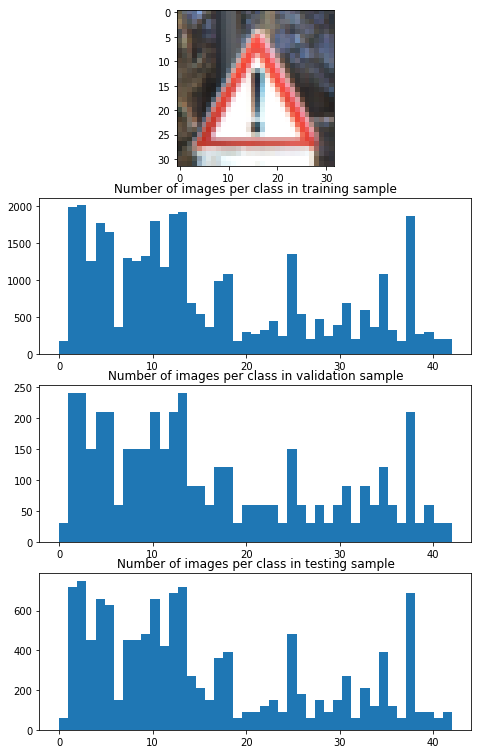

In [3]:

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

fig, axs = plt.subplots(4)
axs[0].imshow(image)
axs[1].hist(y_train, bins=n_classes)
axs[1].set_title('Number of images per class in training sample')
axs[2].hist(y_valid, bins=n_classes)
axs[2].set_title('Number of images per class in validation sample')
axs[3].hist(y_test, bins=n_classes)
axs[3].set_title('Number of images per class in testing sample')
plt.subplots_adjust(left=0.0, right=1.0, top=2.5, bottom=0.0)


## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set 

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


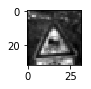

In [12]:
#Function for applying grayscale and normalizing all the data
def Preprocess(X_train, change):
    X_train_grayscale = np.zeros(X_train.shape[:-1])
    X_train_normalized = np.zeros(X_train.shape[:-1])

    if change == True:    
        for i in range(X_train.shape[0]): 
                X_train_grayscale[i] = cv2.cvtColor(X_train[i], cv2.COLOR_RGB2GRAY) 
                X_train_normalized[i] = cv2.normalize(X_train_grayscale[i],  X_train_normalized[i], 0, 1, cv2.NORM_MINMAX)
    else:
        for i in range(6):
            X_train_grayscale[i] = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2GRAY)
            X_train_normalized[i] = cv2.normalize(X_train_grayscale[i],  X_train_normalized[i], 0, 1, cv2.NORM_MINMAX)

    X_train = np.expand_dims(X_train_normalized, axis=-1)
    return X_train

#Training Data
X_train = Preprocess(X_train, 1)

#Validation Data
X_valid = Preprocess(X_valid, 1)

#Testing Data
X_test = Preprocess(X_test, 1)

X_train, y_train = shuffle(X_train, y_train)

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

### Model Architecture

In [ ]:
Used Lenet Achitecture

I added dropout to avoid overfitting and insert regularization

In [13]:
EPOCHS = 10
BATCH_SIZE = 128

def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, drop)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    conv2  = tf.nn.dropout(conv2, drop)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)

    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b

    # SOLUTION: Activation.
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, drop)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b

    # SOLUTION: Activation.
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, drop)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [14]:
#Features and labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
drop = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y,43)

#Training pipeline
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#Model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, drop: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#Train the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, drop: 0.7})

        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i + 1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.777

EPOCH 2 ...
Validation Accuracy = 0.845

EPOCH 3 ...
Validation Accuracy = 0.888

EPOCH 4 ...
Validation Accuracy = 0.916

EPOCH 5 ...
Validation Accuracy = 0.926

EPOCH 6 ...
Validation Accuracy = 0.926

EPOCH 7 ...
Validation Accuracy = 0.935

EPOCH 8 ...
Validation Accuracy = 0.937

EPOCH 9 ...
Validation Accuracy = 0.949

EPOCH 10 ...
Validation Accuracy = 0.947

Model saved


---

## Step 3: Test a Model on New Images


### Load and Output the Images

In [ ]:
Load web images, resize and process them. Later display all five images

['test_images/gt4.jpg', 'test_images/gt5.jpg', 'test_images/gt3.jpg', 'test_images/gt1.jpg', 'test_images/gt7.jpg', 'test_images/gt2.jpg', 'test_images/gt8.jpg']


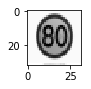

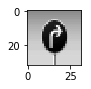

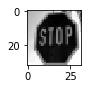

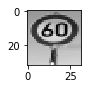

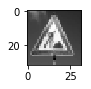

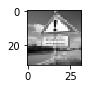

In [15]:
#Reading images and directly converting them into grayscale
images = glob.glob('test_images/gt*.jpg')
print(images)
img = []
for i in range(6):
    img.append(cv2.resize(cv2.imread(images[i]), (32, 32), interpolation = cv2.INTER_AREA))
img = np.asarray(img, dtype=np.float32)

test_normalized = Preprocess(img, 0)

y_norm_test = np.array([5, 33, 14, 3, 25, 18])

for i in range(6):
    image = test_normalized[i].squeeze()
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap='gray')
    

### Predict the Sign Type for Each Image

In [16]:
prediction = tf.argmax(logits, 1)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess = tf.get_default_session()
    result = sess.run(prediction, feed_dict={x: test_normalized, y: y_norm_test, drop: 1.0})
    
print('Class IDs result:', result)

INFO:tensorflow:Restoring parameters from ./lenet
Class IDs result: [ 2 35 14 17 25 17]


### Analyze Performance

In [17]:
#Evaluate the model
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

# Accuracy of new images
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(test_normalized, y_norm_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.921
INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.333


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [18]:
k = 6
softmax = tf.nn.softmax(logits)
topk = tf.nn.top_k(softmax, k)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess = tf.get_default_session()
    probs = sess.run(topk, feed_dict={x: test_normalized, y: y_norm_test, drop: 1.0})
    
print('Top 6 class IDs of each image, and their probabilities:')
print(probs)

INFO:tensorflow:Restoring parameters from ./lenet
Top 6 class IDs of each image, and their probabilities:
TopKV2(values=array([[  7.74221241e-01,   1.78671613e-01,   3.62311378e-02,
          4.94464673e-03,   3.46691092e-03,   7.44749384e-04],
       [  3.75573754e-01,   1.63443908e-01,   8.98169056e-02,
          8.49497765e-02,   5.92240356e-02,   5.28875440e-02],
       [  8.55302513e-01,   4.57176678e-02,   1.74695849e-02,
          1.33096129e-02,   1.14521831e-02,   9.66386218e-03],
       [  8.42137396e-01,   7.89033920e-02,   1.78166721e-02,
          9.22773033e-03,   8.59060697e-03,   6.93127699e-03],
       [  8.09985995e-01,   6.20791018e-02,   4.36521694e-02,
          2.94190533e-02,   1.10333394e-02,   8.57052114e-03],
       [  3.38363707e-01,   1.51391476e-01,   8.95691663e-02,
          7.18787685e-02,   4.26166765e-02,   3.73595431e-02]], dtype=float32), indices=array([[ 2,  1, 31,  5, 21, 11],
       [35, 12, 11, 33, 13,  7],
       [14, 38,  4,  2,  1, 22],
      